In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import sys
sys.path.append('/home/brysongray/fibermetric/fibermetric')
import predict_3D_unet
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np

from torch.utils.data import Dataset, DataLoader

Using device: cuda


In [3]:
imgs = os.listdir('/home/brysongray/bmap/mricloud_atlases/DTIatlas/Adult/tensor1/')
imgs.sort()
masks = os.listdir('/home/brysongray/bmap/mricloud_atlases/DTIatlas/Adult/bmask/')
masks = [mask for mask in masks if mask.endswith('.img')]
masks.sort()

print(imgs)
print(masks)

['s02a_tensor_n.dat', 's03a_tensor_n.dat', 's04a_tensor_n.dat', 's05a_tensor_n.dat', 's06a_tensor_n.dat', 's07a_tensor_n.dat', 's09a_tensor_n.dat', 's10a_tensor_n.dat']
['s02a_bmask.img', 's03a_bmask.img', 's04a_bmask.img', 's05a_bmask.img', 's06a_bmask.img', 's07a_bmask.img', 's09a_bmask.img', 's10a_bmask.img']


In [7]:
image_filename = '/home/brysongray/bmap/mricloud_atlases/DTIatlas/Adult/tensor1/s02a_tensor_n.dat'
mask_filename = '/home/brysongray/bmap/mricloud_atlases/DTIatlas/Adult/bmask/s02a_bmask.img'
image_data = np.fromfile(image_filename, dtype=np.float32)
# load .img file
mask_data = np.fromfile(mask_filename, dtype=np.uint16)
I_ = image_data.reshape(181,6,217,181)


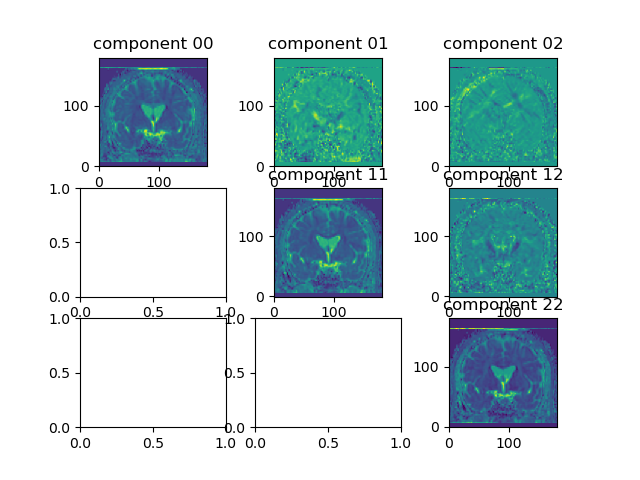

In [8]:
# show a slice
fig,ax_ = plt.subplots(3,3)
for i in range(6):
    if i == 0:
        row = 0
        col = 0
        title = '00'
    elif i == 1:
        row = 1
        col = 1
        title = '11'
    elif i == 2:
        row = 2
        col = 2
        title = '22'
    elif i == 3:
        row = 0
        col = 1
        title = '01'
    elif i == 4:
        row = 0
        col = 2
        title = '02'
    elif i == 5:
        row = 1
        col = 2
        title = '12'
    ax = ax_[row,col]
    ax.imshow(I_[:,i,I_.shape[3]//2],interpolation='none')
    ax.set_title(f'component {title}')
    ax.invert_yaxis()

In [9]:
# now we'll reshape it into a 3x3 matrix with components on the last two axes
I = np.zeros((I_.shape[0],I_.shape[2],I_.shape[3],3,3))
# assign components but note xyz versus zyx
I[...,0,0] = I_[:,2]
I[...,1,1] = I_[:,1]
I[...,2,2] = I_[:,0]
I[...,0,1] = I_[:,5]
I[...,0,2] = I_[:,4]
I[...,1,2] = I_[:,3]
I[...,1,0] = I_[:,5]
I[...,2,0] = I_[:,4]
I[...,2,1] = I_[:,3]

In [10]:
rgb_image = np.stack((I[...,0,0],I[...,1,1],I[...,2,2]),axis=-1)
rgb_image = rgb_image / np.max(rgb_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


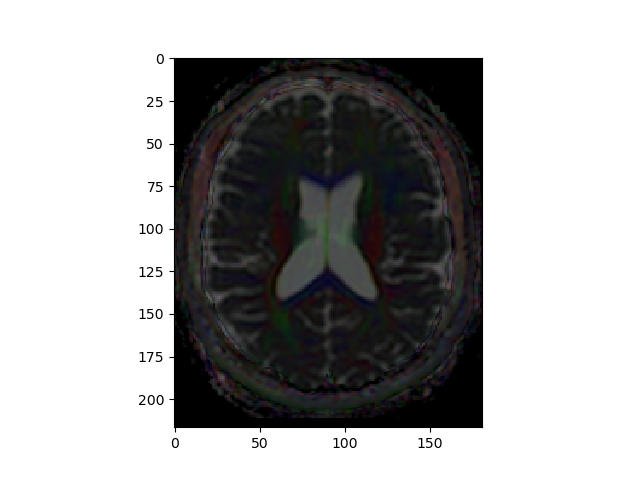

In [12]:
plt.figure()
plt.imshow(rgb_image[rgb_image.shape[0]//2],interpolation='none')

In [13]:
# this function does eigendecomposition on last two axes, and sorts in increasing eigenvalue
d,v = np.linalg.eigh(I)

Text(0.5, 0.98, 'red-row-SI, green-col-AP, blue-slice-LR')

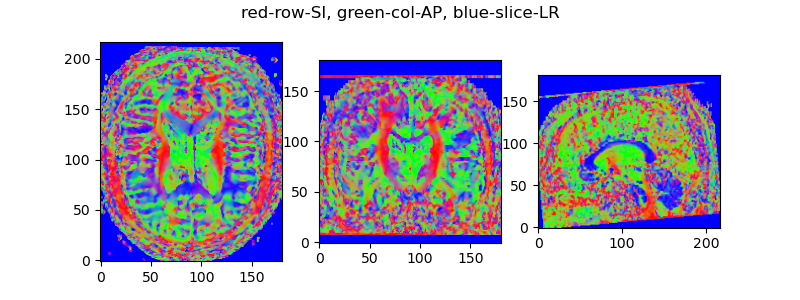

In [15]:
fig,ax = plt.subplots(1,3,figsize=(8,3))
ax[0].imshow(np.abs(v[v.shape[0]//2,:,:,:,-1]))
ax[0].invert_yaxis()
ax[1].imshow(np.abs(v[:,v.shape[1]//2,:,:,-1]))
ax[1].invert_yaxis()
ax[2].imshow(np.abs(v[:,:,v.shape[2]//2,:,-1]))
ax[2].invert_yaxis()
fig.suptitle('red-row-SI, green-col-AP, blue-slice-LR')

In [24]:
# load pytorch model
# model = torch.load('/home/brysongray/fibermetric/outputs/model_e100_lr1e5.pth')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = predict_3D_unet.UNet2D(3).to(device)
model.load_state_dict(torch.load('/home/brysongray/fibermetric/outputs/model_e100_lr1e5.pth'))
filename = '/home/brysongray/bmap/mricloud_atlases/DTIatlas/Adult/tensor1/s10a_tensor_n.dat'
mask = '/home/brysongray/bmap/mricloud_atlases/DTIatlas/Adult/bmask/s10a_bmask.img'
dataset = predict_3D_unet.DiffusionTensorDataset(filename, mask)
loss_fn = nn.MSELoss().to(device)
test_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [21]:
# test model
loss, accuracy = predict_3D_unet.test_loop(model, loss_fn, test_loader, device)

Loss:  0.06993476301431656
Loss:  0.08305768668651581
Loss:  0.08393259346485138
Loss:  0.08427271991968155
Loss:  0.05644109472632408
Loss:  0.09319887310266495
Test Error: Avg loss: 0.078473 
 Accuracy: 0.144338 



In [25]:
loss, accuracy = predict_3D_unet.test_loop(model, loss_fn, test_loader, device)

Loss:  0.07728227972984314
Loss:  0.08233890682458878
Loss:  0.08581189066171646
Loss:  0.08264462649822235
Loss:  0.07506659626960754
Loss:  0.07667501270771027
Test Error: Avg loss: 0.079970 
 Accuracy: 0.135865 



In [26]:
print(f'accuracy (diff in estimated and true eigenvector component): {accuracy}')
angular_error = (np.arccos(-1*accuracy)- np.arccos(accuracy))/2 * 180/np.pi
print(f'accuracy in degrees: {angular_error}')

accuracy (diff in estimated and true eigenvector component): 0.13586506495873132
accuracy in degrees: 7.808645367591586


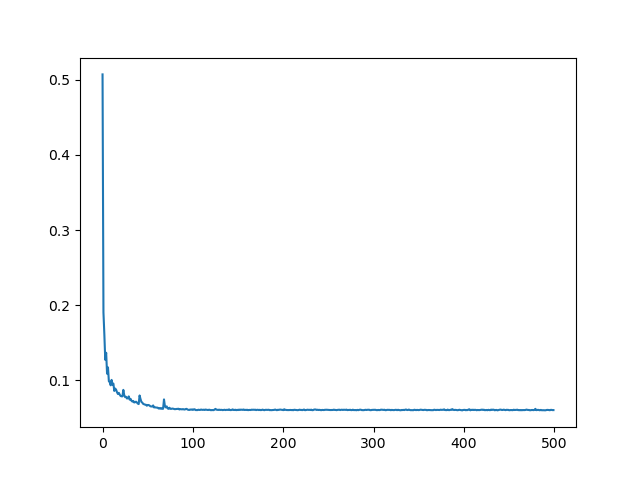

In [30]:
losses = np.load('../outputs/losses.npy')
plt.figure()
plt.plot(losses)